In [1]:
# load and filter data

import sys
import time
tic = time.time() 
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\TP4_ECAL-\\utils')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\tracking')
from data_loading import *
from tqdm import tqdm
from matplotlib import pyplot as plt
from track_reconstruction import *
from hit import Hit
from track3D import Track3D
from track import Track
from parameters import *

file_path = 'C:\\Users\\Pascal\\Desktop\\TP4a\\data\\run_000002\\data_0000.root' 
import pandas as pd
import uproot
import numpy as np


N_cons_events = 25000 # number of events to consider

br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'evt_flags']
evt_tree = 'event_data;1'
hits_tree = 'event_data;1'

with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
df_evts = pd.DataFrame.from_dict(evts_dict)
df_hits = pd.DataFrame.from_dict(hits_dict)
df_hits['timestamp_event'] = df_evts['timestamp']
df_hits = df_hits[0:N_cons_events]

og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

# create tracks
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)

            ## check if track has a "good" chi2 value
            if track.is_good_2D_fit():
            
                # worth making a precise track
                #track.precise_track()
                
                ## compute the time of the track
                dt = track.get_time_interval()
                if dt is not None:
                    dts.append(dt)


    return tracks, dts
    import time
t = time.time()
trackss, dts = create_tracks(df_hits)
print("Average track creation time : ", 1000*(time.time()-t)/len(df_hits),"ms")
good_tracks = [t for t in trackss if t.is_good_2D_fit()]
print("Number of good tracks : ", len(good_tracks))

selected 51.42% of all events


100%|██████████| 12854/12854 [05:36<00:00, 38.24it/s]

Average track creation time :  26.154717353671227 ms
Number of good tracks :  11075


In [2]:
def give_amplitude_rel(T3D):
    hits = T3D.x.hits + T3D.y.hits
    A = []
    z = []
    for h in hits:
        z.append(h.get_pos()[1])
        A.append(h.value)
    z = max(z)-z
    sorted_z, sorted_A = zip(*sorted(zip(z,A)))

    bigA = np.asarray(sorted_A)
    bigz = np.asarray(sorted_z).astype(int)
    return bigA, bigz

def give_amplitude(T3D):
    hits = T3D.x.hits + T3D.y.hits
    A = []
    z = []
    for h in hits:
        z.append(h.get_pos()[1])
        A.append(h.value)
    sorted_z, sorted_A = zip(*sorted(zip(z,A)))

    bigA = np.asarray(sorted_A)
    bigz = np.asarray(sorted_z).astype(int)
    return bigA, bigz

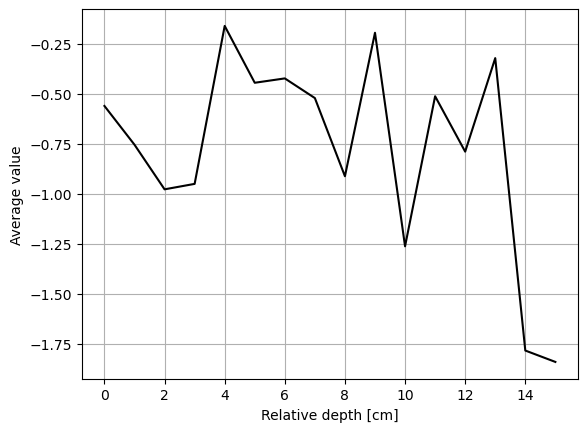

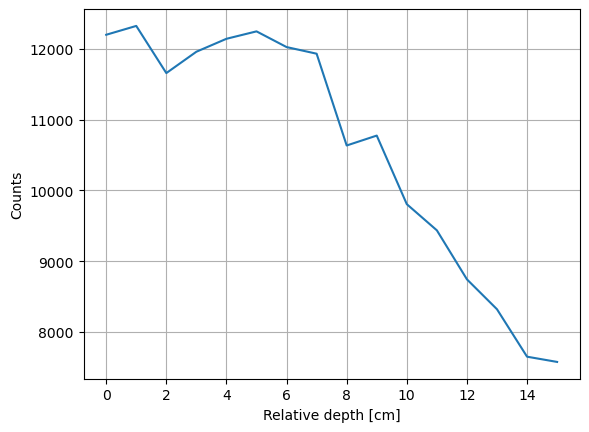

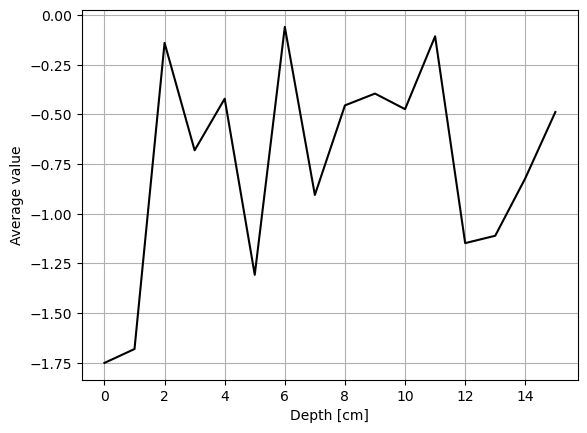

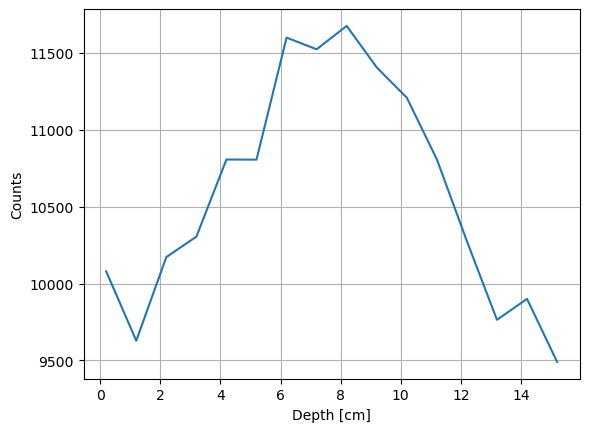

In [3]:
t = good_tracks[0]

bigZ = np.linspace(0,15,16)
bigA = 0*bigZ
count = 0*bigZ
bigAp = 0*bigZ
countp = 0*bigZ

for t in good_tracks:
    A,z = give_amplitude_rel(t)
    Ap,zp = give_amplitude(t)
    for i in range(len(z)):
        bigA[z[i]]+=A[i]
        count[z[i]]+=1
        bigAp[zp[i]]+=Ap[i]
        countp[zp[i]]+=1

for i in range(len(bigZ)):
    bigA[i] = bigA[i]/count[i]
    bigAp[i] = bigAp[i]/countp[i]
plt.figure()
plt.plot(bigZ,bigA,'k')
plt.grid()
plt.xlabel("Relative depth [cm]")
plt.ylabel("Average value")
plt.figure()
plt.plot(bigZ,count)
plt.xlabel("Relative depth [cm]")
plt.ylabel("Counts")
plt.grid()
plt.figure()
plt.plot(bigZ,bigAp,'k')
plt.grid()
plt.xlabel("Depth [cm]")
plt.ylabel("Average value")
plt.figure()
plt.plot(bigZ+0.2,countp)
plt.xlabel("Depth [cm]")
plt.ylabel("Counts")
plt.grid()

Text(0, 0.5, '$y_0$')

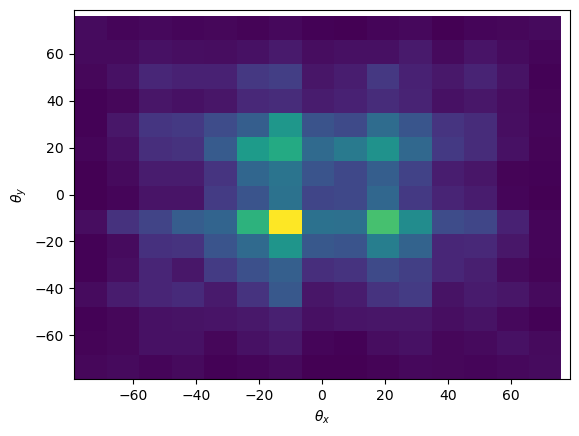

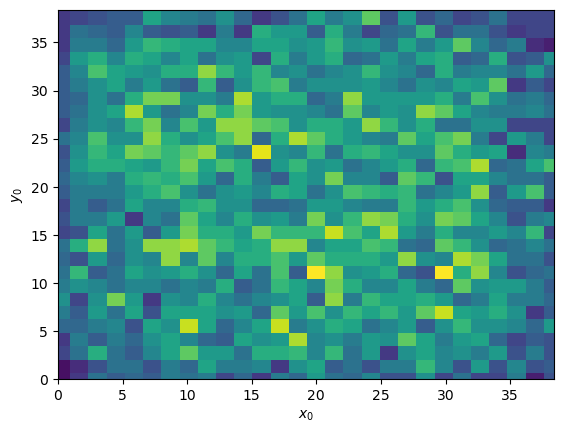

In [4]:
thetax= []
thetay= []
x0 = []
y0 = []
for t in good_tracks:
    thetax.append(t.x.t)
    thetay.append(t.y.t)
    x0.append(t.x.x0)
    y0.append(t.y.x0)
plt.figure()
plt.hist2d(np.arctan(thetax)*180/np.pi,np.arctan(thetay)*180/np.pi, 15)
plt.xlim([np.arctan(-5)*180/np.pi, np.arctan(5)*180/np.pi])
plt.ylim([np.arctan(-5)*180/np.pi, np.arctan(5)*180/np.pi])
plt.xlabel(r"$\theta_x$")
plt.ylabel(r"$\theta_y$")
plt.figure()
plt.hist2d(x0,y0, 100)
plt.xlim([0,38.4])
plt.ylim([0,38.4])
plt.xlabel(r"$x_0$")
plt.ylabel(r"$y_0$")

Text(0, 0.5, 'Count')

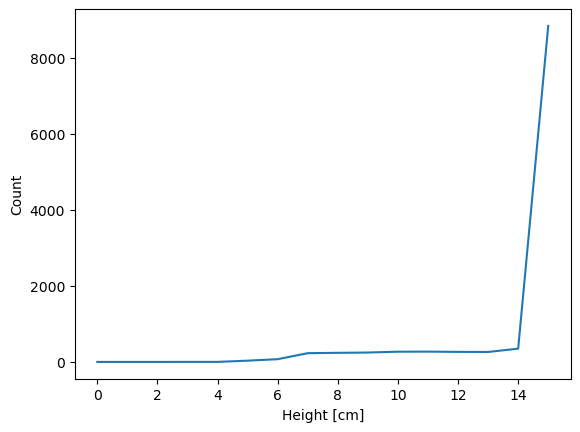

In [7]:
bigZ = np.linspace(0,15,16)*0
for t in good_tracks:
    hits = t.x.hits + t.y.hits
    z0 = 0
    for h in hits:
        if z0 < h.get_pos()[1]:
            z0 = h.get_pos()[1]
    z0 = int(z0)
    bigZ[z0]+=1
plt.figure()
plt.plot(bigZ)
plt.xlabel("Height [cm]")
plt.ylabel("Count")
grid on
    